# Analyse syntaxique et exploration du corpus avec Neo4j et spaCy

Ce notebook a pour objectif d'explorer un corpus de texte à l'aide de **SpaCy** et de **Neo4j**, afin de répondre à des questions métier et d'analyser les relations syntaxiques entre les mots.

## Objectifs

1. Comprendre le **modèle de graphe** (nœuds, arêtes, orientation, propriétés).  
2. Extraire avec SpaCy les **tokens**, **lemmes**, **POS** et **dépendances grammaticales**.  
3. Interroger le graphe avec **Cypher** pour identifier :
   - Tous les verbes du corpus.  
   - Les sujets d’un verbe donné.  
   - Les objets directs associés aux verbes.  
   - La fréquence de chaque dépendance grammaticale.  
   - Les adjectifs qualifiant un nom donné.  
   - Les verbes les plus utilisés.  
   - Construire des couples **Sujet–Verbe–Objet** et un **graphe de cooccurrence**.


## Connexion à la base Neo4j

In [17]:
from dotenv import load_dotenv
import os
from neo4j import GraphDatabase
import spacy
from spacy import displacy
import pandas as pd

# Charger les variables d'environnement depuis .env
load_dotenv()

# Récupérer les valeurs
uri = os.getenv("NEO4J_URI")
user = os.getenv("NEO4J_USER")
password = os.getenv("NEO4J_PASSWORD")

# Connexion à Neo4j
driver = GraphDatabase.driver(uri, auth=(user, password))

## Visualisation des données 

In [18]:
# Chargement du modèle français de SpaCy (version légère)
nlp = spacy.load("fr_core_news_sm")

Chaque relation extraite contient les champs suivants :  

- **dependent** : mot dépendant  
- **dependent_lemma** : lemme du mot dépendant  
- **dependent_pos** : catégorie grammaticale du mot dépendant  
- **head** : mot "tête" du token  
- **head_lemma** : lemme de la tête  
- **head_pos** : catégorie grammaticale de la tête  
- **dep_type** : type de relation syntaxique

In [19]:
import pandas as pd

# Lire le texte depuis le fichier
with open("text1.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Analyse avec SpaCy
doc = nlp(text)

# Créer un DataFrame avec tous les tokens et renommer les colonnes pour Neo4j dès le départ
df_tokens = pd.DataFrame([{
    "dependent": token.text,
    "dependent_lemma": token.lemma_,
    "dependent_pos": token.pos_,
    "head": token.head.text,
    "head_lemma": token.head.lemma_,
    "head_pos": token.head.pos_,
    "dep_type": token.dep_,
    "is_alpha": token.is_alpha,
    "is_stop": token.is_stop
} for token in doc])

# Filtrer les tokens alphabétiques et non stop words pour Neo4j
df_relations = df_tokens[(df_tokens["is_alpha"]) & (~df_tokens["is_stop"])].copy()

# Affichage pour vérification
df_relations


,dependent,dependent_lemma,dependent_pos,head,head_lemma,head_pos,dep_type,is_alpha,is_stop
5,couché,coucher,VERB,couché,coucher,VERB,ROOT,True,False
7,bonne,bon,ADJ,heure,heure,NOUN,amod,True,False
8,heure,heure,NOUN,couché,coucher,VERB,obl:mod,True,False
13,peine,peine,NOUN,fermaient,fermer,VERB,obl:mod,True,False
16,bougie,bougie,NOUN,peine,peine,NOUN,nmod,True,False
...,...,...,...,...,...,...,...,...,...
1875,reverrais,revoir,VERB,figurais,figurer,VERB,conj,True,False
1876,mieux,mieux,ADV,reverrais,revoir,VERB,advmod,True,False
1881,heure,heure,NOUN,l’,l’,NOUN,flat:name,True,False
1884,serais,être,AUX,reverrais,revoir,VERB,advcl,True,False


In [20]:
# Visualisation de la structure syntaxique du texte 
displacy.render(doc, style="dep", jupyter=True)

## Insertion des données

Insertion des relations de dépendance syntaxique dans Neo4j.

    Paramètres :
    - tx : transaction Neo4j
    - dependent : mot dépendant
    - dependent_lemma : lemme du mot dépendant
    - dependent_pos : catégorie grammaticale du mot dépendant
    - head : mot "tête" du token
    - head_lemma : lemme de la tête
    - head_pos : catégorie grammaticale de la tête
    - dep_type : type de relation syntaxique
    

In [21]:
def insert_relation(tx, dependent, dependent_lemma, dependent_pos,
                    head, head_lemma, head_pos, dep_type):
    tx.run("""
        MERGE (d:Word {text: $dependent})
        SET d.pos = $dependent_pos, d.lemma = $dependent_lemma

        MERGE (h:Word {text: $head})
        SET h.pos = $head_pos, h.lemma = $head_lemma

        MERGE (d)-[:DEPENDS_ON {type: $dep_type}]->(h)
    """, dependent=dependent, dependent_lemma=dependent_lemma, dependent_pos=dependent_pos,
         head=head, head_lemma=head_lemma, head_pos=head_pos, dep_type=dep_type)


In [22]:
# Insérer toutes les relations filtrées dans Neo4j
with driver.session() as session:
    for rel in df_relations.to_dict("records"):
        session.write_transaction(
            insert_relation,
            rel["dependent"],
            rel["dependent_lemma"],
            rel["dependent_pos"],  
            rel["head"],
            rel["head_lemma"],
            rel["head_pos"],       
            rel["dep_type"]
        )

# Message de confirmation
print("Toutes les relations ont été insérées dans Neo4j !")


/var/folders/jr/zwjg8smd0n78jpvcd26rt4pm0000gn/T/ipykernel_56379/3009699571.py:4: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(


Toutes les relations ont été insérées dans Neo4j !


## Analyse métier 

### Lister les verbes 

In [25]:
# Requête Cypher pour récupérer tous les verbes
query = """
MATCH (v:Word)
WHERE v.pos = "VERB"
RETURN DISTINCT v.lemma AS Verbe
"""

# Exécution de la requête et récupération dans un DataFrame
with driver.session() as session:
    result = session.run(query)
    # Convertir le résultat en liste de dictionnaires
    verbs = [record.data() for record in result]

# Créer un DataFrame pandas
df_verbs = pd.DataFrame(verbs)
df_verbs

,Verbe
0,fermer
1,avoir
2,m’
3,chercher
4,éveiller
...,...
131,reposer
132,suspendre
133,figurer
134,représenter


### Retrouver les sujets du verbe demander

In [38]:
query = """
MATCH (s:Word)-[r:DEPENDS_ON {type: "nsubj"}]->(v:Word)
WHERE v.lemma = "fermer"
RETURN DISTINCT s.text AS Sujet, v.text AS Verbe
"""

# Exécution de la requête et récupération des résultats
with driver.session() as session:
    result = session.run(query)
    rows = [record.data() for record in result]

# Créer un DataFrame pandas
df_sujets = pd.DataFrame(rows)

# Affichage
df_sujets

,Sujet,Verbe
0,yeux,fermaient


### Récupérer les objets directs

In [40]:
query = """
MATCH (o:Word)-[r:DEPENDS_ON {type: "obj"}]->(v:Word {pos:"VERB"})
RETURN v.lemma AS verbe, o.text AS objet
ORDER BY verbe, objet
"""

# Exécution de la requête
with driver.session() as session:
    result = session.run(query)
    rows = [record.data() for record in result]

# Création du DataFrame
df_objets = pd.DataFrame(rows)

# Affichage
df_objets

,verbe,objet
0,avoir,instant
1,avoir,temps
2,avoir,traits
3,chercher,sommeil
4,choquer,raison
5,demander,heure
6,deviner,orientation
7,devoir,cheminée
8,donne,courage
9,donner,entier


### Compter le nombre de dépendances grammaticales

In [41]:

query = """
MATCH ()-[r:DEPENDS_ON]->()
RETURN r.type AS Dependance, COUNT(*) AS NbOccurrences
ORDER BY NbOccurrences DESC
"""

# Exécution de la requête
with driver.session() as session:
    result = session.run(query)
    rows = [record.data() for record in result]

# Création du DataFrame
df_dependencies = pd.DataFrame(rows)

# Affichage
df_dependencies


,Dependance,NbOccurrences
0,nmod,72
1,obj,54
2,xcomp,50
3,obl:mod,49
4,amod,48
5,conj,44
6,ROOT,42
7,advmod,40
8,obl:arg,39
9,advcl,35


### Lister les adjectifs qui qualifient un nom

In [42]:
query = """
MATCH (adj:Word)-[r:DEPENDS_ON {type:"amod"}]->(n:Word)
WHERE adj.pos = "ADJ" AND n.pos = "NOUN"
RETURN adj.text AS Adjectif, n.text AS Nom
ORDER BY Nom, Adjectif
"""

# Exécution de la requête
with driver.session() as session:
    result = session.run(query)
    rows = [record.data() for record in result]

# Création du DataFrame
df_adj_noms = pd.DataFrame(rows)
df_adj_noms


,Adjectif,Nom
0,inaccoutumés,actes
1,éteinte,bougie
2,soulevé,bras
3,déserte,campagne
4,récente,causerie
5,petit,chemin
6,rabattu,chemises
7,obscure,chose
8,organiques,craquements
9,ankylosé,côté


### Mesurer les verbes les plus utilisés

In [43]:
query = """
MATCH (v:Word)
WHERE v.pos = "VERB"
RETURN v.lemma AS Verbe, COUNT(*) AS nbOccurence
ORDER BY nbOccurence DESC
"""

# Exécution de la requête
with driver.session() as session:
    result = session.run(query)
    rows = [record.data() for record in result]

# Création du DataFrame
df_verbes = pd.DataFrame(rows)
df_verbes


,Verbe,nbOccurence
0,venir,4
1,pouvoir,4
2,avoir,3
3,chercher,3
4,croire,3
...,...,...
131,reposer,1
132,suspendre,1
133,figurer,1
134,représenter,1


### Construire des couples Sujet–Verbe–Objet

In [44]:
import pandas as pd

query = """
MATCH (s:Word)-[:DEPENDS_ON {type:"nsubj"}]->(v:Word {pos:"VERB"})
MATCH (o:Word)-[:DEPENDS_ON {type:"obj"}]->(v)
RETURN s.lemma AS Sujet, v.lemma AS Verbe, o.lemma AS Objet
ORDER BY Verbe, Sujet, Objet
"""

with driver.session() as session:
    result = session.run(query)
    rows = [record.data() for record in result]

df_svo = pd.DataFrame(rows)
df_svo


,Sujet,Verbe,Objet
0,esprit,devoir,cheminée
1,malade,devoir,cheminée
2,sommeil,détendre,esprit
3,femme,naître,position
4,Ève,naître,côte
5,église,parler,rivalité
6,réflexion,prendre,tour
7,mémoire,présenter,mur


# Analyse des cooccurrences lexicales
Nous extrayons les cooccurrences de mots (non stopwords, uniquement alphabétiques) à partir des phrases du corpus.  
Cela permet d’identifier quels mots apparaissent fréquemment ensemble et de préparer une visualisation en tableau ou en graphe.

In [ ]:
cooccurrences = []
for sent in doc.sents:
    tokens = [t for t in sent if t.is_alpha and not t.is_stop]  
    for i in range(len(tokens)):
        for j in range(i + 1, len(tokens)):
            # Créer une paire (mot_i, mot_j) => cooccurrence
            cooccurrences.append((tokens[i].lemma_, tokens[j].lemma_))

In [47]:
df = pd.DataFrame(cooccurrences)
df

,0,1
0,coucher,bon
1,coucher,heure
2,bon,heure
3,peine,bougie
4,peine,éteint
...,...,...
5425,mieux,être
5426,mieux,éveillé
5427,heure,être
5428,heure,éveillé


### Insertion des cooccurrences dans Neo4j

Nous allons stocker les cooccurrences de mots sous forme de graphe dans Neo4j.  
- Chaque mot est représenté comme un **nœud** (`Word`).  
- Une relation `COOCCURS_WITH` relie deux mots qui apparaissent ensemble dans une même phrase.  
- La relation porte un attribut `weight` (poids) qui compte combien de fois la cooccurrence a été observée dans le corpus.  



In [48]:
def insert_cooccurrence(tx, word1, word2):
    tx.run("""
        // Créer ou réutiliser le nœud correspondant au premier mot
        MERGE (w1:Word {text: $word1})

        // Créer ou réutiliser le nœud correspondant au deuxième mot
        MERGE (w2:Word {text: $word2})

        // Créer ou réutiliser une relation COOCCURS_WITH entre les deux mots (non orientée)
        MERGE (w1)-[r:COOCCURS_WITH]-(w2)

        // Si la relation est nouvelle, on initialise son poids à 1
        ON CREATE SET r.weight = 1           

        // Si la relation existe déjà, on incrémente son poids (+1)
        ON MATCH SET r.weight = r.weight + 1 
    """, word1=word1, word2=word2)


with driver.session() as session:
    for w1, w2 in cooccurrences:  
        # Pour chaque paire de mots cooccurrents, on appelle la fonction d'insertion
        session.write_transaction(insert_cooccurrence, w1, w2)

print("Toutes les cooccurrences ont été insérées dans Neo4j !")


/var/folders/jr/zwjg8smd0n78jpvcd26rt4pm0000gn/T/ipykernel_56379/2988742892.py:23: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_cooccurrence, w1, w2)


Toutes les cooccurrences ont été insérées dans Neo4j !


### Visualisation du graphe de cooccurrences

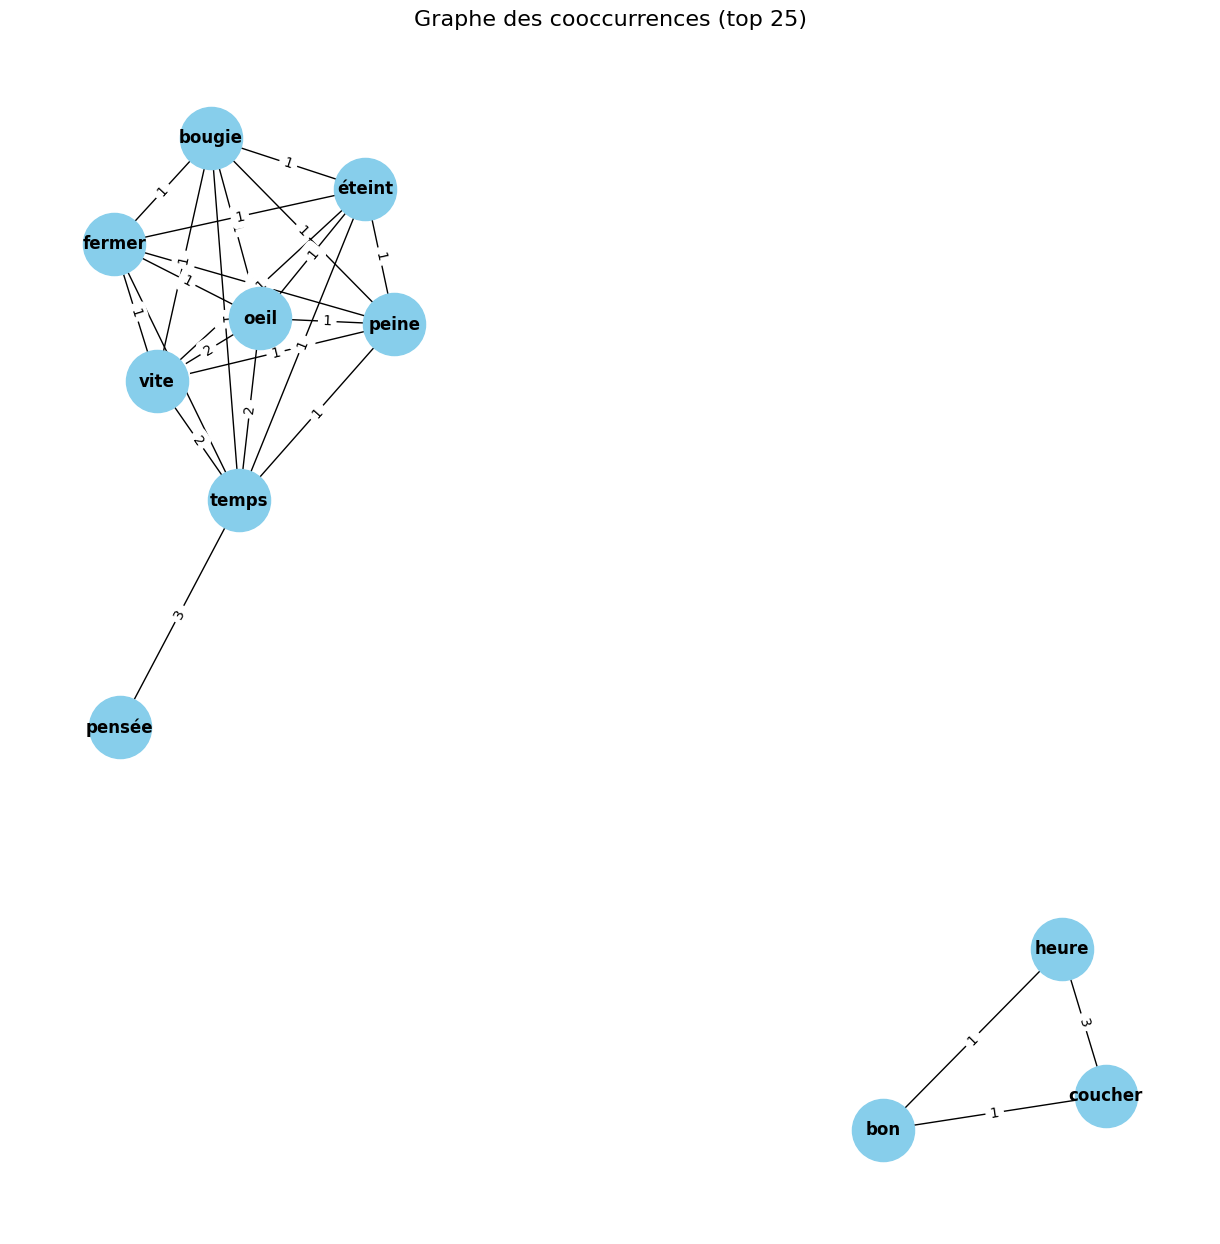

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

#Requête pour récupérer les cooccurrences depuis Neo4j 
query = """
MATCH (w1)-[r:COOCCURS_WITH]->(w2)
RETURN w1.text AS mot1, w2.text AS mot2, r.weight AS poids
LIMIT 25
"""

with driver.session() as session:
    result = session.run(query)
    edges = [(record["mot1"], record["mot2"], record["poids"]) for record in result]

# Création du graphe NetworkX
G = nx.Graph()
for u, v, w in edges:
    G.add_edge(u, v, weight=w)

# Position des nœuds avec plus d'espacement
pos = nx.spring_layout(G, k=1.0, iterations=50)  # k plus grand = plus d’espace

# Taille de la figure plus grande pour éviter chevauchement
plt.figure(figsize=(12, 12))

# Dessin du graphe
nx.draw(
    G, pos,
    with_labels=True,
    node_size=2000,          # nœuds plus grands
    node_color="skyblue",
    font_size=12,
    font_weight="bold"
)

# Ajouter les labels pour les arêtes (poids)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10)

plt.title("Graphe des cooccurrences (top 25)", fontsize=16)
plt.show()
